In [1]:
import numpy as np
from collections import defaultdict
from tqdm.notebook import tqdm

rng = np.random.default_rng(42)

In [2]:
# Note that this is not really epsilon-greedy (as we explore uniformly with epsilon*2) but this eases naming convention
def egreedy_logging_policy(X, epsilon):
    # Determine optimal action
    optimal_action = -1
    if X:
        optimal_action = np.argmax(p_R_X1)
    else:
        optimal_action = np.argmax(p_R_X0)

    # Flip coin to explore
    explore = rng.random() < epsilon
    if explore:
        return int(not optimal_action), epsilon
    else:
        return optimal_action, 1.0 - epsilon

def generate_sample(epsilon):
    # Generate covariates
    X = rng.random() > (1.0 - p_X)

    # Get action
    A, P = egreedy_logging_policy(X, epsilon)

    # Get reward
    if X:
        R = rng.random() < p_R_X1[A]
    else:
        R = rng.random() < p_R_X0[A]

    return X, A, P, R

In [3]:
alphas = [0.5, 0.6, 0.7, 0.8, 0.9]
epsilons = np.logspace(-4, 0, 10) * .5

# Reward probability
p_R_X0 = np.asarray([1.0, 0.7])
p_R_X1 = np.asarray([0.0, 0.7])

# Policies to evaluate
target_policies = [
    (1.0, 0.0), # Always action 0
    (0.0, 1.0), # Always action 1
]

true_gaps = np.zeros((len(alphas), len(epsilons)))
ideal_IPS_gaps = np.zeros((len(alphas), len(epsilons)))
biased_IPS_gaps = np.zeros((len(alphas), len(epsilons)))

N = 1_000_000

for alpha_idx, alpha in tqdm(enumerate(alphas)):
    for epsilon_idx, epsilon in enumerate(epsilons):        
        # Discrete covariate probabilities (X)
        p_X = alpha

        # Generate logged data
        X = []
        A = []
        P = []
        R = []
        for _ in range(N):
            x, a, p, r = generate_sample(epsilon)
            X.append(x)
            A.append(a)
            P.append(p)
            R.append(r)
        X = np.asarray(X)
        A = np.asarray(A)
        P = np.asarray(P)
        R = np.asarray(R)


        def DM_estimate(A, P, R, pi):
            r_hat_numer = np.zeros_like(pi)
            r_hat_denom = np.zeros_like(pi)
            for a, r in zip(A,R):
                r_hat_numer[a] += r
                r_hat_denom[a] += 1
                
            r_hat = r_hat_numer / r_hat_denom            
            return np.sum([r_hat[a]*pi[a] for a in range(len(pi))])
                
        def IPS_estimate(A, P, R, pi):    
            denominator = 0
            numerator = 0
            W = []
            Pt = []
            for a, p, r in zip(A,P,R):
                w = pi[a] / p
                denominator += r * w
                numerator += 1
                W.append(w)
                Pt.append(pi[a])
            return denominator / numerator, W, Pt

        # Ground truth
        ground_truth = [
            (1-alpha) * p_R_X0[0] + alpha * p_R_X1[0],
            (1-alpha) * p_R_X0[1] + alpha * p_R_X1[1]
        ]

        GAP = ground_truth[1] - ground_truth[0]
        
        # Ideal IPS (with correct but onobservable propensities)
        ideal_IPS_estimates = []
        for policy in target_policies:
            R_hat, W, Pt = IPS_estimate(A, P, R, policy)
            ideal_IPS_estimates.append(R_hat)
        
        IDEAL_IPS_GAP = ideal_IPS_estimates[1] - ideal_IPS_estimates[0]

        # Estimate propensities (without taking confounders into account)
        P_hat_1 = A.sum() / len(A)
        P_hat_0 = 1.0 - P_hat_1
        pi_hat = [P_hat_0, P_hat_1]
        P_hat = np.asarray([pi_hat[a] for a in A])
        
        if epsilon == 1.0:
            print(P_hat)

        def exact_bias_estimate(R, Pt, P, P_hat):
             return (R * Pt * (1/P_hat - 1/P)).mean()

        # Biased IPS
        biased_IPS_estimates = []
        for policy in target_policies:
            R_hat, W, Pt = IPS_estimate(A, P_hat, R, policy)
            biased_IPS_estimates.append(R_hat)

            bias_exact = exact_bias_estimate(R, Pt, P, P_hat)
            # print('Bias estimate (exact):\t\t\t', bias_exact)
        
        BIASED_IPS_GAP = biased_IPS_estimates[1] - biased_IPS_estimates[0]
        
        # Aggregate errors
        true_gaps[alpha_idx, epsilon_idx] += GAP
        ideal_IPS_gaps[alpha_idx, epsilon_idx] += IDEAL_IPS_GAP
        biased_IPS_gaps[alpha_idx, epsilon_idx] += BIASED_IPS_GAP

0it [00:00, ?it/s]

# Plotting

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
new_rc_params = {'text.usetex': True,
    'svg.fonttype': 'none',
    'font.family': 'Linux Libertine',
    'text.latex.preamble': r'\usepackage{libertine}',
    'mathtext.fontset': 'custom',
    'mathtext.rm': 'libertine',
    'mathtext.it': 'libertine:italic',
    'mathtext.bf': 'libertine:bold'
    }
mpl.rcParams.update(new_rc_params)
plt.style.use('tableau-colorblind10')
plt.rc('axes', axisbelow=True)

In [5]:
# Taken from
# https://gist.github.com/AndiH/c957b4d769e628f506bd

# Tableau 20 Colors
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Tableau Color Blind 10
tableau20blind = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]
  
# Rescale to values between 0 and 1 
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)
for i in range(len(tableau20blind)):  
    r, g, b = tableau20blind[i]  
    tableau20blind[i] = (r / 255., g / 255., b / 255.)

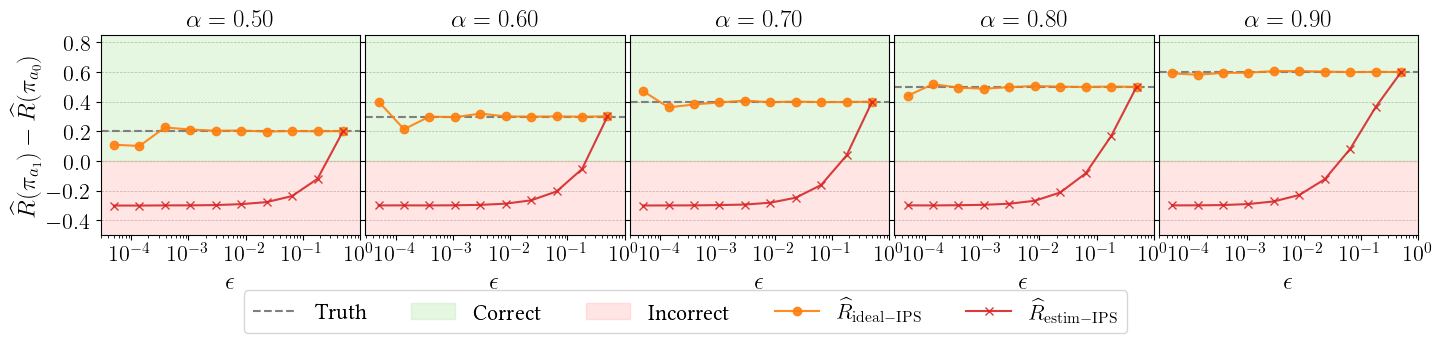

In [6]:
fig, axes = plt.subplots(1, len(alphas), figsize=(17,2.6), sharey=True)
fontsize=20

plt.subplots_adjust(wspace=.02)
for ax_idx, ax in enumerate(axes):

    ax.set_title(fr'$\alpha={alphas[ax_idx]:.2f}$', fontsize=fontsize-2)
    truth = true_gaps[ax_idx,:].mean()
    ax.axhline(truth, ls='--', label='Truth', color=tableau20[14])
    ax.fill_between([0, 2], [0, 0],[1, 1], color=tableau20[5], alpha = .25, label='Correct')
    ax.fill_between([0, 2], [0, 0],[-1, -1], color=tableau20[7], alpha = .25, label='Incorrect')

    ax.plot(epsilons, ideal_IPS_gaps[ax_idx,:].ravel(), marker='o', label=r'$\widehat{R}_{\rm ideal-IPS}$', color=tableau20[2], alpha=.9)

    ax.plot(epsilons, biased_IPS_gaps[ax_idx,:].ravel(), marker='x', label=r'$\widehat{R}_{\rm estim-IPS}$', color=tableau20[6], alpha=.9)
    
    ax.set_xscale('log')

    ax.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
    ax.set_xlabel('$\epsilon$', fontsize=fontsize-2)
    
    if ax_idx == 0:
        ax.set_ylabel(r'$\widehat{R}(\pi_{a_{1}}) - \widehat{R}(\pi_{a_{0}})$', fontsize=fontsize-2)

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize - 4) 

    ax.set_ylim(-.5, .85)
    ax.set_xlim(None, 1)

axes[0].legend(fontsize=fontsize-4, ncols=6, bbox_to_anchor=(4.0,-.22))
plt.savefig('CONSEQUENCES23_Fig1.pdf', bbox_inches='tight', transparent=True)
plt.show()